<a href="https://colab.research.google.com/github/verneh/datasci/blob/master/bikeshare_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pint pip yapf scipy numpy matplotlib pandas seaborn sympy beautifulsoup4 lxml html5lib modsimpy tables

     |████████████████████████████████| 194kB 3.4MB/s 
     |████████████████████████████████| 194kB 9.8MB/s 
  Created wheel for modsimpy: filename=modsimpy-1.1.3-cp36-none-any.whl size=20356 sha256=0c3a9a5145a45f4b3ea8828531e415b1b79f74c88b8be1306ad1f7618b426abd
  Stored in directory: /root/.cache/pip/wheels/59/34/ac/e82f103fbfb5d961b1a4d2b8e89bb6629a4c0b242e5373cbfa
Successfully built modsimpy


In [2]:
# import functions from the modsim library
from modsim import *

# set the random number generator. so our data remains the same.
np.random.seed(49)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We're simulating a bikeshare system from two locations. 'dap' and 'padilla' which are based in the Ortigas CBD.

**Functions**

In [0]:
# simulate probability of arrival.
def step(state, p1, p2):

    # state.clock += 1

    if flip(p1):
        bike_to_padilla(state)
        # print('Moving to Padilla')
        
    if flip(p2):
        bike_to_dap(state)
        # print('Moving to Dap')

# move bike from dap to padilla. value of empty is the
# number of unhappy customers in a location.
def bike_to_padilla(state):

    if state.dap == 0:
        state.dap_empty +=1
        return
    state.dap -=1
    state.padilla +=1        

# move bike from padilla to dap.
def bike_to_dap(state):

    if state.padilla == 0:
        state.padilla_empty +=1
        return
    state.padilla -=1
    state.dap +=1  

def decorate_bikeshare():

    decorate(title='Dap-Padilla Bikeshare',
         xlabel='Time Step (minutes)',
         ylabel='Number of Bikes') 

# number of time steps -> num_steps. we remove state in the argument on the final parts of the code.
def run_simulation(p1, p2, num_steps):

    # dap = TimeSeries()
    # padilla = TimeSeries()

    state = State(dap=10, padilla=2, 
                  dap_empty=0, padilla_empty=0)

    for i in range(num_steps):
        step(state, p1, p2)
        # dap[i] = state.dap
        # padilla[i] = state.padilla

    return state    

    # plot(dap, label='Dap')
    # plot(padilla, label='Padilla')


**Function Tests**

Initial state that indicate the number of bikes on each location as well as two different states.

In [0]:
bikeshare_01 = State(dap=7, padilla=3)
bikeshare_02 = State(dap=3, padilla=7)

Which state to work on?

In [0]:
bike_to_dap(bikeshare_01)
bike_to_padilla(bikeshare_02)

In [6]:
bikeshare_01

,values
dap,8
padilla,2


In [7]:
bikeshare_02

,values
dap,2
padilla,8


**Metrics for running simulation**

Time to evaluate if the metrics for this design is good or not.

In [0]:
new = State(dap=8, padilla=4, dap_empty=0, padilla_empty=0)

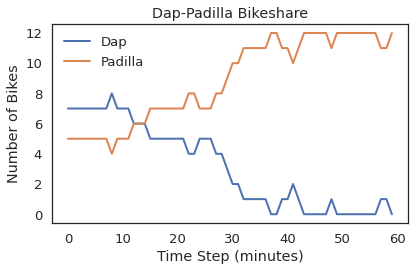

In [14]:
run_simulation(new, 0.4, 0.2, 60)
decorate_bikeshare()

More bikes available for padilla. Less bikes available for Dap which leads to...

...our count of unhappy customers at each location. 

In [16]:
new.dap_empty

2

In [17]:
new.padilla_empty

0

Suppose we want to add a clock to find out how many steps have elapsed.

In [0]:
simulation = State(dap=10, padilla=2, 
                  dap_empty=0, padilla_empty=0,
                  clock=0)

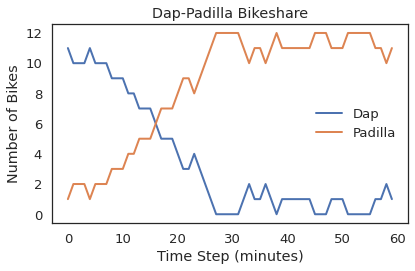

In [19]:
run_simulation(simulation, 0.4, 0.2, 60)
decorate_bikeshare()

Less number of bikes available for Dap.

In [20]:
simulation

,values
dap,1
padilla,11
dap_empty,5
padilla_empty,0
clock,60


Another way of doing this would be to add state within function, remove state from argument and hide clock within function. We get this result...

In [34]:
 state = run_simulation(0.4, 0.2, 60)
 state

,values
dap,0
padilla,12
dap_empty,3
padilla_empty,0


In [35]:
state.dap_empty

3

In [40]:
state = run_simulation(0.2, 0.2, 60)
state

,values
dap,7
padilla,5
dap_empty,0
padilla_empty,0


In [41]:
state = run_simulation(0.6, 0.2, 60)
state

,values
dap,1
padilla,11
dap_empty,9
padilla_empty,0


So we know that if we assign higher probability for dap, the more we have unhappy customers waiting. The lower probability dap has, the more available bikes there are.

In [0]:
p2 = 0.2
num_steps = 60
p1_array = linspace(0, 1, 11)

In [45]:
for p1 in p1_array:
    state = run_simulation(p1, p2, num_steps)
    print(p1, state.dap_empty)

0.0 0
0.1 0
0.2 0
0.30000000000000004 0
0.4 0
0.5 8
0.6000000000000001 26
0.7000000000000001 20
0.8 26
0.9 32
1.0 37


So what we are seeing here are the number of unhappy customers in the dap station based on the p1 array.

In [0]:
sweep = SweepSeries()

for p1 in p1_array:
    state = run_simulation(p1, p2, num_steps)
    sweep[p1] = state.dap_empty

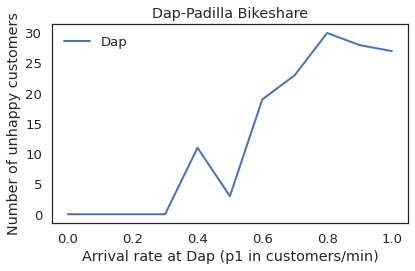

In [47]:
plot(sweep, label='Dap')

decorate(title='Dap-Padilla Bikeshare',
         xlabel='Arrival rate at Dap (p1 in customers/min)', 
         ylabel='Number of unhappy customers')

So we used Sweep instead of print and plot the results. As we can see, there's a lot of unhappy customers when the arrival rate is high.

**Optimizing Sweep**

In [0]:
# to optimize sweep, we turn this into a function
def sweep_p1(p1_array):
    p2 = 0.2
    num_steps = 60
    sweep = SweepSeries()
    
    for p1 in p1_array:
        state = run_simulation(p1, p2, num_steps)
        sweep[p1] = state.dap_empty
        
    return sweep

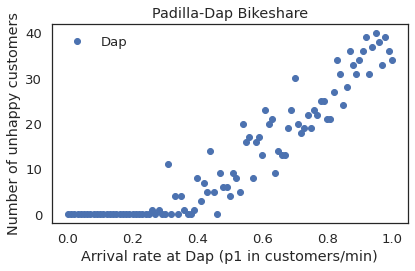

In [53]:
p1_array = linspace(0, 1, 101)
sweep = sweep_p1(p1_array)
plot(sweep, 'bo', label='Dap')
decorate(title='Padilla-Dap Bikeshare',
         xlabel='Arrival rate at Dap (p1 in customers/min)', 
         ylabel='Number of unhappy customers')

What about arrival to Padilla?

In [0]:
def sweep_p2(p2_array):
    p1 = 0.5
    num_steps = 60
    sweep = SweepSeries()
    
    for p2 in p2_array:
        state = run_simulation(p1, p2, num_steps)
        sweep[p2] = state.dap_empty
        
    return sweep

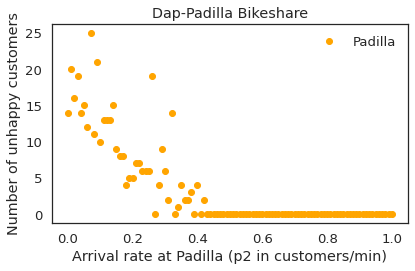

In [57]:
p2_array = linspace(0, 1, 101)
sweep = sweep_p2(p2_array)
plot(sweep, 'bo', label='Padilla', color='orange')

decorate(title='Dap-Padilla Bikeshare',
         xlabel='Arrival rate at Padilla (p2 in customers/min)', 
         ylabel='Number of unhappy customers')

Longer we go, less number of unhappy customers.

Simulations tend to be random and the results vary from one to another. To get a clearer picture, we need to run multiple simulations. 

In [0]:
def run_multiple_simulations(p1, p2, num_steps, num_runs):
    
    results = TimeSeries()
    
    for i in range(num_runs):
        state = run_simulation(p1, p2, num_steps)
        results[i] = state.dap_empty + state.padilla_empty
        
    return results

We test our function with sample parameters.

In [63]:
p1 = 0.3
p2 = 0.3
num_steps = 60
num_runs = 10
run_multiple_simulations(p1, p2, num_steps, num_runs)

,values
0,0
1,6
2,3
3,0
4,0
5,4
6,9
7,0
8,0
9,2


These are the total unhappy customers found at both locations.

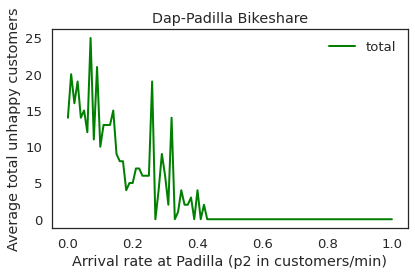

In [66]:
# will need to reset this at sweep p1 array to see Dap's arrival rate!
plot(sweep, label='total', color='green')
    
decorate(title='Dap-Padilla Bikeshare',
         xlabel='Arrival rate at Padilla (p2 in customers/min)', 
         ylabel='Average total unhappy customers')

On route to Padilla, we can see here that higher arrival rates occur within 0.0 - 0.4 customers/min.